In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Resizing
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
set_global_policy('mixed_float16') 

2025-08-19 13:45:41.261897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755611141.610027      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755611141.707018      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def build_alexnet(input_shape=(227, 227, 3), num_classes=10):
    model = Sequential([
        Resizing(227, 227),
        Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Conv2D(256, (5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=2),

        Flatten(),
        Dense(1024, activation='relu'), # reduced from 4096 to 1024 for CIFAR-10
        Dropout(0.5),
        Dense(1024, activation='relu'), # reduced from 4096 to 1024 for CIFAR-10
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

In [5]:
def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=64):
    optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks to reduce LR and stop early if no improvement
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        verbose=1)
    return history


In [6]:
def evaluate_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"\nTest Accuracy: {acc*100:.2f}%")
    return loss, acc


In [7]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.title('Training History')
    plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755611175.246777      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755611175.247476      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1755611182.036726      83 service.cc:148] XLA service 0x7a61cc002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755611182.038068      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755611182.038086      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755611182.784058      83 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-19 13:46:29.290338: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,27,27,96]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,27,27,256]{3,2,1,0}, f16[256,5,5,96]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue

  3/782 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.0582 - loss: 3.0833 

I0000 00:00:1755611211.995699      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3280 - loss: 1.8445

2025-08-19 13:47:19.133657: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[256,5,5,96]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,27,27,96]{3,2,1,0}, f16[16,27,27,256]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-19 13:47:20.597495: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.464053481s
Trying algorithm eng19{k2=2} for conv (f16[256,5,5,96]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,27,27,96]{3,2,1,0}, f16[16,27,27,256]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config"

782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - accuracy: 0.3282 - loss: 1.8439 - val_accuracy: 0.3497 - val_loss: 1.8763 - learning_rate: 0.0100
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5576 - loss: 1.2418 - val_accuracy: 0.5285 - val_loss: 1.3270 - learning_rate: 0.0100
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.6569 - loss: 0.9840 - val_accuracy: 0.6263 - val_loss: 1.0610 - learning_rate: 0.0100
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.7097 - loss: 0.8342 - val_accuracy: 0.6796 - val_loss: 0.9349 - learning_rate: 0.0100
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7565 - loss: 0.6981 - val_accuracy: 0.7359 - val_loss: 0.7680 - learning_rate: 0.0100
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7929 - loss: 0.5936 - val_accuracy: 0.7358 - val_loss: 0.7938 - learning_rate: 0.0100
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8174 - loss: 0.5343

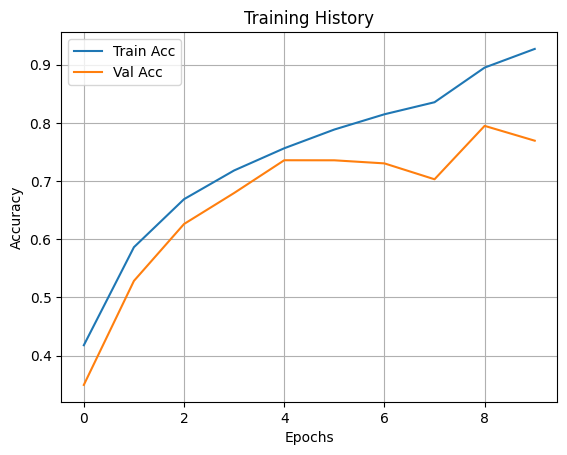

In [8]:
x_train, y_train, x_test, y_test = load_data()
model = build_alexnet(input_shape=(227, 227, 3), num_classes=10)
history = train_model(model, x_train, y_train, x_test, y_test, epochs=10)
evaluate_model(model, x_test, y_test)
plot_history(history)